<a href="https://colab.research.google.com/github/aakashduggal/Calories-Burn-Prediction/blob/main/final_project_smart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading data
!git clone https://github.com/rslim087a/track


Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163 (from 1)
Receiving objects: 100% (12163/12163), 156.98 MiB | 17.57 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random


In [ ]:
datadir = 'track'
columns = ['center','left','right','steering','throttlee','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', 1)  #none = -1
data.head()

,center,left,right,steering,throttlee,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [ ]:
def path_lead(path):
  head,tail = ntpath.split(path)
  return tail
  data['center'] = data['center'].apply(path_lead)
  data['left'] = data['left'].apply(path_lead)
  data['right'] = data['right'].apply(path_lead)
  print(data.head())


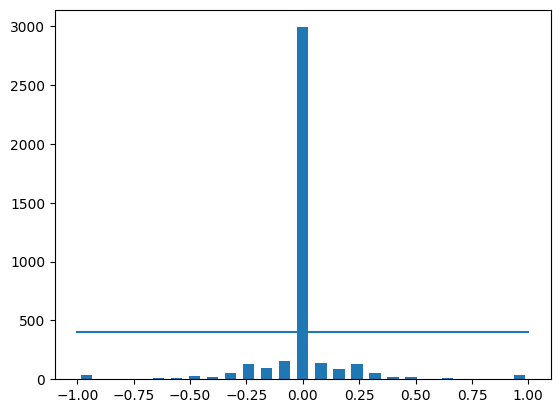

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)  # Corrected the typo
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print('total data:',len(data))
print(data.shape)

total data: 4053
(4053, 7)


In [ ]:
remove_list = []
#samples_per_bin = 100  # Assuming you have defined this variable

for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)

    # Shuffle and trim the list after the loop
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]  # Keep only indices to be removed
    remove_list.extend(list_)  # Extend with correct variable `list_`

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)  # Drop all at once
print('remaining:', len(data))


removed: 2590
remaining: 1463


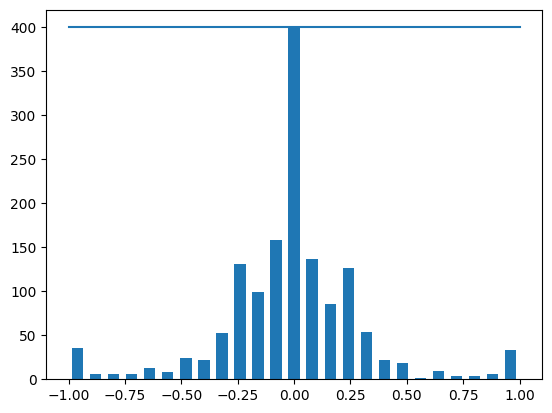

In [ ]:
hist, _ = np.histogram(data['steering'], num_bins)  # Corrected `histrogram` to `histogram`
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [ ]:
def load_img_steering(datadir, df):  # Corrected function name
    image_path = []
    steering = []

    for i in range(len(data)):  # Use df instead of data
        indexed_data = data.iloc[i] # same as above
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]

        # Center image append
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))

        # Left image append
        image_path.append(os.path.join(datadir, left.strip()))  # Corrected append9 to append
        steering.append(float(indexed_data[3]) + 0.15)

        # Right image append
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)  # Corrected indexed_dta to indexed_data

    # Convert lists to numpy arrays
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)

    return image_paths, steerings  # Moved outside the loop


In [ ]:
image_paths, steerings = load_img_steering(datadir + '/IMG',data)

<ipython-input-12-18d89c53ccd0>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-12-18d89c53ccd0>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
<ipython-input-12-18d89c53ccd0>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]) + 0.15)
<ipython-input-12-18d89c53ccd0>:

In [ ]:
len(image_paths)

4389

In [ ]:
len(steerings)

4389

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))


Training Samples: 3511
Valid Samples: 878


Text(0.5, 1.0, 'Validation set')

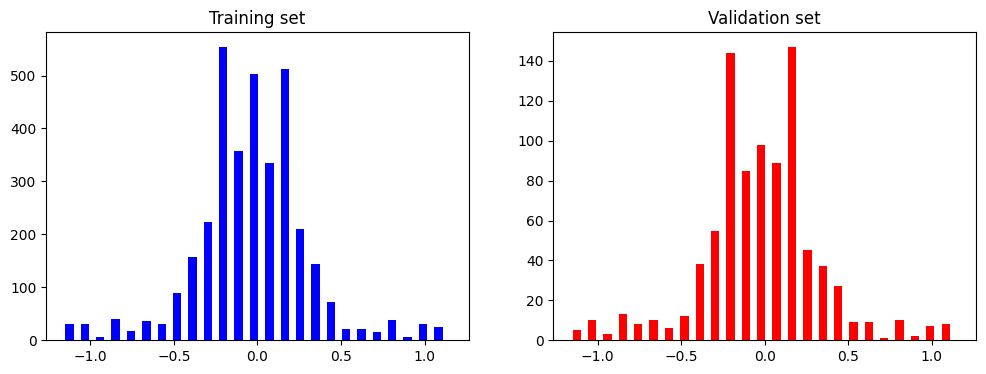

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')  # Corrected 'bluce' to 'blue'
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')  # Corrected 'clor' to 'color'
axes[1].set_title('Validation set')


Text(0.5, 1.0, 'Zoomed Image')

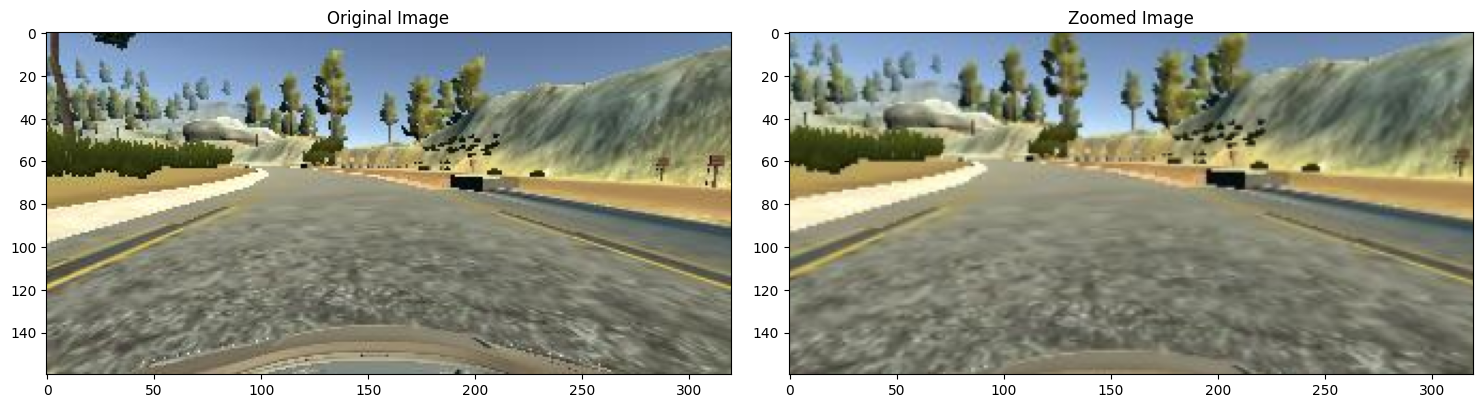

In [ ]:
import random
from matplotlib import pyplot as plt
import matplotlib.image as mping
# !pip install imgaug
from imgaug import augmenters as iaa


def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

# The file path was incorrect and had an extra '.j' that was removed
# Make sure the image exists in your current directory.
image = '/content/track/IMG/center_2018_07_16_17_11_49_640.jpg' # Replace with a valid path
original_image = mping.imread(image)
zoomed_image = zoom(original_image)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

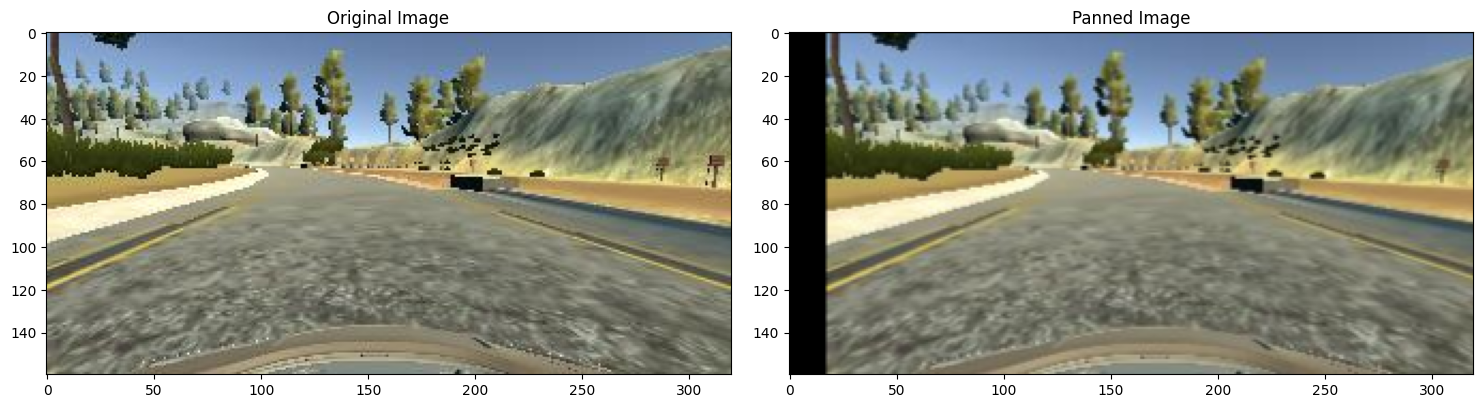

In [ ]:
import random
from matplotlib import pyplot as plt
import matplotlib.image as mping
# !pip install imgaug
from imgaug import augmenters as iaa


def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

# Instead of relying on potentially inconsistent paths in image_paths,
# directly access the image using a relative path.
# Ensure the image 'center_2018_07_16_17_11_49_640.jpg' exists in the 'track/IMG' directory
# relative to your current working directory or notebook location.
image = 'track/IMG/center_2018_07_16_17_11_49_640.jpg'
original_image = mping.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

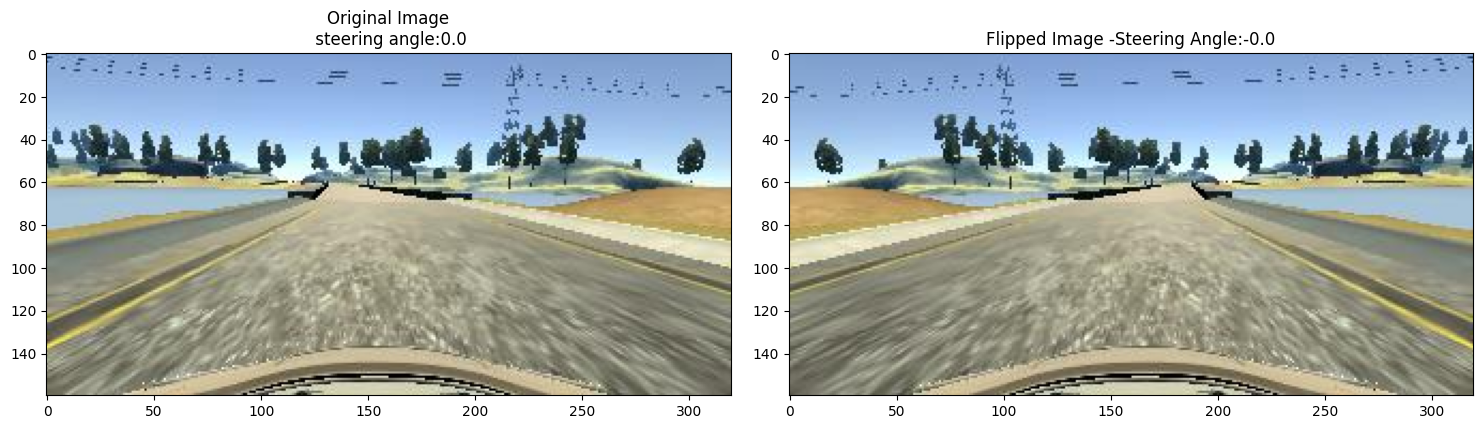

In [ ]:
import random
from matplotlib import pyplot as plt
import matplotlib.image as mping
# !pip install imgaug
from imgaug import augmenters as iaa
import cv2 # Import the cv2 module

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0,1000)
image = image_paths[random_index]

# Fix the file path by removing the extra 'C:\\Users\\Amer\\Desktop\\new_track\\IMG\\'
image = image.replace('C:\\Users\\Amer\\Desktop\\new_track\\IMG\\', '')
steering_angle = steerings[random_index]

original_image = mping.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig,axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title(f'Original Image\n steering angle:{steering_angle}')

axs[1].imshow(flipped_image)
# Corrected the typo in set_title from 'sset_title' to 'set_title'
axs[1].set_title('Flipped Image -' + 'Steering Angle:' + str(flipped_steering_angle))
axs[1].imshow(flipped_image)

In [ ]:
def random_augment(image, steering_angle):
  image = mping.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() <0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image,steering_angle)
  # Removed the extra  "image, steering_angle = img_random_flip(image, steering-angle)"
  return image, steering_angle # Return the values outside the if block

In [ ]:
def img_preprocess(img):
  img = img[60:135,:,:]
  imag = cv2.cvtColor(img, cv2.COLOR_RGB2YUN)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

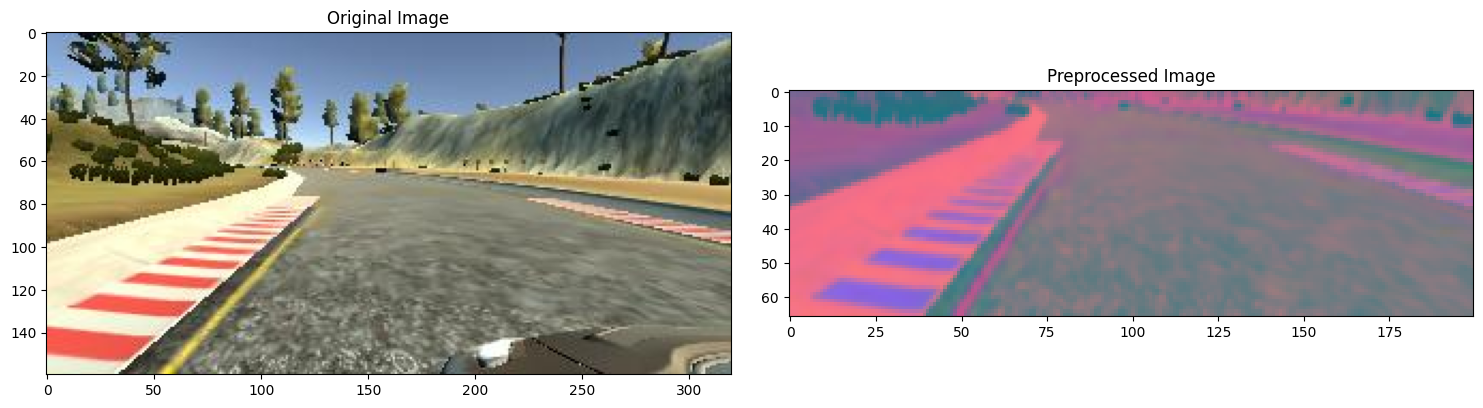

In [ ]:
import matplotlib.image as mping

def img_preprocess(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Corrected the color space
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

image = '/content/track/IMG/left_2018_07_16_17_11_48_057.jpg' # Corrected file path
original_image = mping.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
!nvidia-smi

Sun Dec  8 09:02:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if is_training and random.random() < 0.6:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index]) # Fixed indentation, corrected "steerong_ang" to "steering_ang"

      else:
        im = mping.imread(image_paths[random_index])
        steering = steering_ang[random_index]

        im  = img_preprocess(im)
      batch_img.append(im) # Fixed indentation
      batch_steering.append(steering) # Fixed indentation
    yield (np.asarray(batch_img), np.asarray(batch_steering))
    # Fixed indentation, added comma between arrays
    x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
# Corrected the typo: X_valild to X_valid

In [ ]:

import numpy as np
import random
import matplotlib.image as mping
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Corrected the color space
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

def random_augment(image_path, steering_angle):
  """
  This function is a placeholder for your augmentation logic.
  It currently just reads and preprocesses the image without augmentation.
  """
  image = mping.imread(image_path)
  image = img_preprocess(image)
  return image, steering_angle # Return image and steering angle

def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            if istraining and random.random() < 0.6:

                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])  # Closed parentheses correctly
            else:
                im = mping.imread(image_paths[random_index])
                steering = steering_ang[random_index]
                im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))


# Replace these with your actual data loading and preprocessing steps
image_paths = ['/content/track/IMG/center_2018_07_16_17_11_43_724.jpg', '/content/track/IMG/center_2018_07_16_17_11_43_792.jpg']  # your image paths
steering_angles = [0.1, 0.2, -0.3]  # your steering angles

min_length = min(len(image_paths), len(steering_angles))
image_paths = image_paths[:min_length]
steering_angles = steering_angles[:min_length]

# Split data into training and validation sets (example 80/20 split)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=42)

# Generate batches - the generator yields a tuple, so unpack it as a tuple
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, False))

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

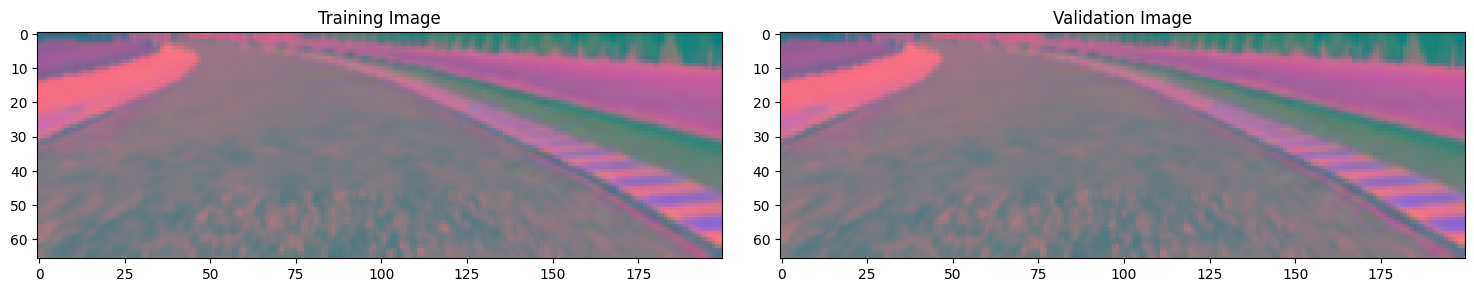

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, (5,5), strides=(2,2), activation= 'elu'))
  model.add(Conv2D(64, (5,5), activation= 'elu'))


  model.add(Flatten())
  model.add(Dense(100, activation= 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = tf.Keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

  model = nvidia_model()
  print(model.summary())

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam # Import Adam from tf.keras.optimizers

from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError



def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (5, 5), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    # Directly use tf.keras.optimizers.Adam
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

    return model

# Call the function to create the model and assign it to the variable 'model'
model = nvidia_model()
print(model.summary())

TensorFlow version: 2.17.1
Keras version: 3.5.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 18, 64)           │          76,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, 100, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle=True)  # shuffle is a parameter of fit()

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 87s 267ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - loss: 1.6840e-13 - mean_squared_error: 1.6840e-13 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 79s 265ms/step - loss: 1.8745e-04 - mean_squared_error: 1.8745e-04 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 76s 255ms/step - loss: 5.9983e-13 - mean_squared_error: 5.9983e-13 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 251ms/step - loss: 1.2650e-13 - mean_squared_error: 1.2650e-13 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 252ms/step - loss: 1.4826e-13 - mean_squared_error: 1.4826e-13 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 69s 232ms/step

Text(0.5, 0, 'Epoch')

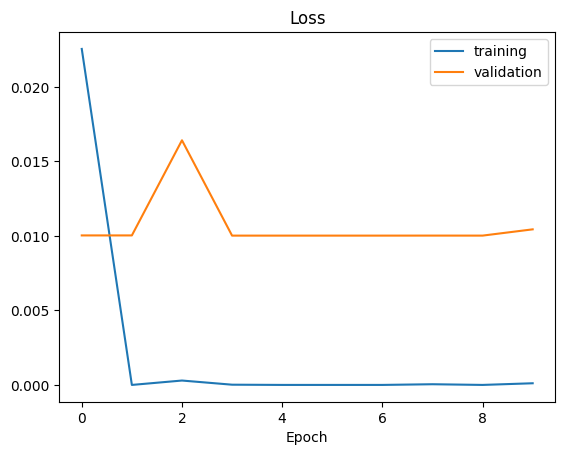

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) # Changed 'histroy' to 'history'
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>